In [1]:
import numpy as np
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
import astropy.units as u
from galpy.potential import MWPotential2014, vcirc
from galpy.util import bovy_conversion

/usr/lib/python3/dist-packages/galpy/util/bovy_conversion.py:8: FutureWarning: galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)



Exponential disk (thin disk)

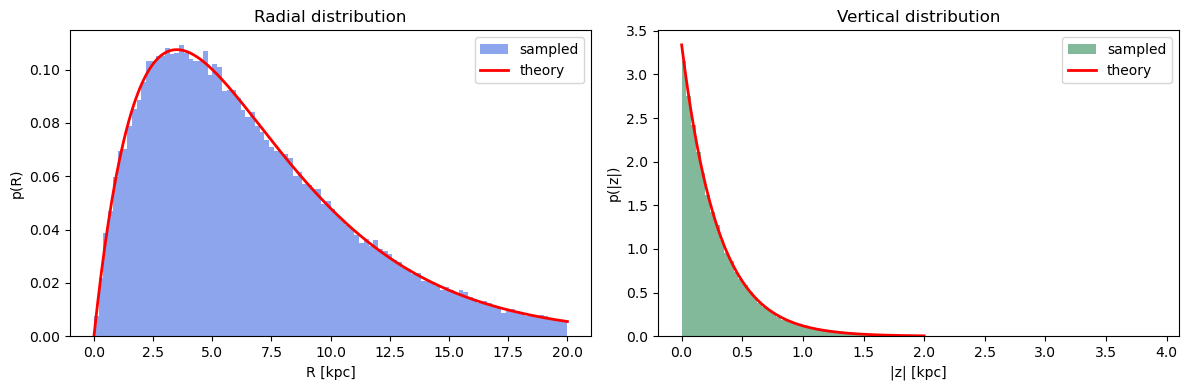

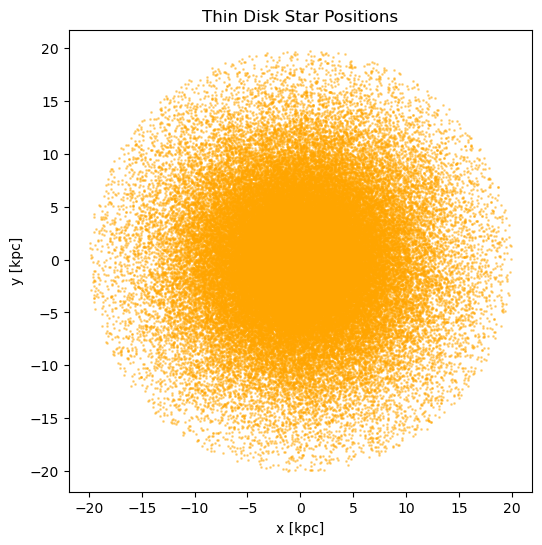

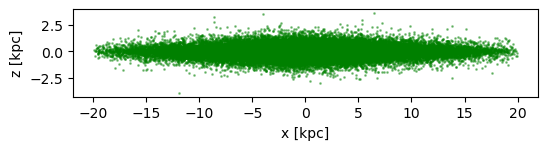

In [2]:
def sample_exponential_disk(N, lR, lz, Rmax=None):
    """
    Generate positions (R, φ, z) from a double-exponential disk density:
    ρ(R,z) ∝ exp(-R/lR) * exp(-|z|/lz)

    Parameters
    ----------
    N : int
        Number of stars to sample
    lR : Quantity
        Radial scale length (e.g. 3.5 * u.kpc)
    lz : Quantity
        Vertical scale height (e.g. 0.3 * u.kpc)
    Rmax : Quantity or None
        Optional maximum radius cutoff (e.g. 15 * u.kpc)

    Returns
    -------
    R, phi, z : Quantity arrays
    """

    R = np.random.gamma(shape=2.0, scale=lR.value, size=N) * lR.unit
    z = np.random.choice([-1, 1], size=N) * np.random.exponential(lz.value, size=N) * lz.unit
    phi = np.random.uniform(0, 2*np.pi, size=N) * u.rad

    if Rmax is not None:
        mask = R < Rmax
        R, z, phi = R[mask], z[mask], phi[mask]

    return R, phi, z


# Example usage: thin disk
N = 100000
lR_thin = 3.5 * u.kpc
lz_thin = 0.3 * u.kpc
Rmax=20

R, phi, z = sample_exponential_disk(N, lR_thin, lz_thin, Rmax=Rmax*u.kpc)

# Convert to Cartesian
x = R * np.cos(phi)
y = R * np.sin(phi)

# Check that the distributions look right
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Radial histogram
axs[0].hist(R.value, bins=100, density=True, alpha=0.6, color='royalblue', label='sampled')
Rgrid = np.linspace(0, Rmax, 400)
pdf_R = (Rgrid / lR_thin.value**2) * np.exp(-Rgrid / lR_thin.value)
axs[0].plot(Rgrid, pdf_R / np.trapz(pdf_R, Rgrid), 'r', lw=2, label='theory')
axs[0].set_xlabel("R [kpc]"); axs[0].set_ylabel("p(R)")
axs[0].legend(); axs[0].set_title("Radial distribution")

# Vertical histogram
zabs = np.abs(z.value)
axs[1].hist(zabs, bins=100, density=True, alpha=0.6, color='seagreen', label='sampled')
zgrid = np.linspace(0, 2, 400)
pdf_z = (1/lz_thin.value) * np.exp(-zgrid/lz_thin.value)
axs[1].plot(zgrid, pdf_z / np.trapz(pdf_z, zgrid), 'r', lw=2, label='theory')
axs[1].set_xlabel("|z| [kpc]"); axs[1].set_ylabel("p(|z|)")
axs[1].legend(); axs[1].set_title("Vertical distribution")

plt.tight_layout(); plt.show()



plt.figure(figsize = (6,6))
plt.title("Thin Disk Star Positions")

plt.scatter(x.value, y.value, s=1, alpha=0.4, color='orange')
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.gca().set_aspect('equal', 'box')

plt.figure(figsize = (6,6))
plt.scatter(x.value, z.value, s=1, alpha=0.4, color='green')
plt.xlabel("x [kpc]")
plt.ylabel("z [kpc]")
plt.gca().set_aspect('equal', 'box')
plt.show()

Thick disk distribution

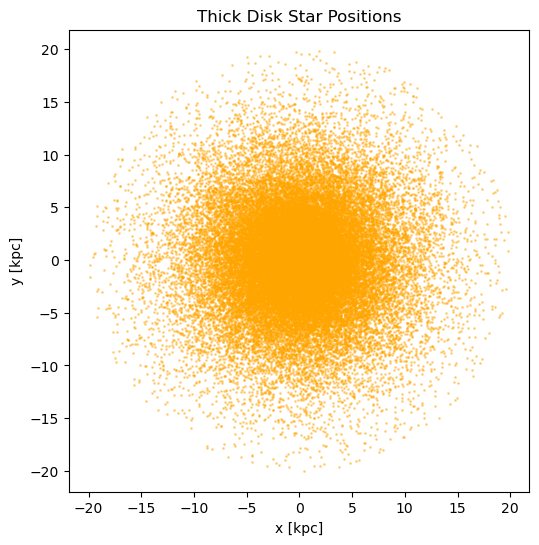

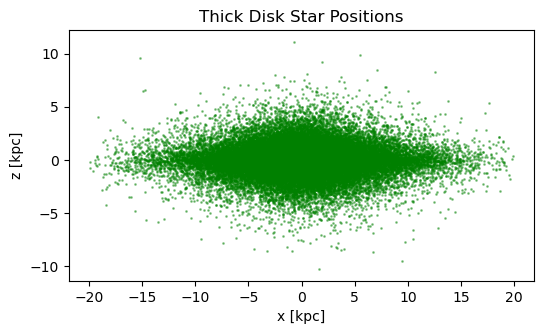

In [3]:
N = 50000  # number of stars

# Parameters from assignment
lR_thick = 2.9 * u.kpc
lz_thick = 1.0 * u.kpc
sigma_thick = 55 * u.km/u.s
ro = 8.0 * u.kpc
vo = 220.0 * u.km/u.s
Rmax = 20

# Generate spatial positions
R, phi, z = sample_exponential_disk(N, lR_thick, lz_thick, Rmax=Rmax*u.kpc)

# Compute circular velocities at each R
vc = np.array([vcirc(MWPotential2014, (Ri/ro).value) for Ri in R]) * vo

# Sample velocity components
#    Gaussian scatter around mean circular motion
vR = np.random.normal(0, sigma_thick.value, len(R)) * u.km/u.s
vT = np.random.normal(vc.value, sigma_thick.value, len(R)) * u.km/u.s
vz = np.random.normal(0, sigma_thick.value, len(R)) * u.km/u.s

# Convert to Cartesian coordinates
x = R * np.cos(phi)
y = R * np.sin(phi)


# Quick visualization
plt.figure(figsize=(6,6))
plt.scatter(x.value, y.value, s=1, alpha=0.4, color='orange')
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.gca().set_aspect('equal', 'box')
plt.title("Thick Disk Star Positions")
plt.show()

# Vertical distribution check
plt.figure(figsize= (6,6))
plt.scatter(x.value, z.value, s=1, alpha=0.4, color='green')
plt.xlabel("x [kpc]")
plt.ylabel("z [kpc]")
plt.gca().set_aspect('equal', 'box')
plt.title("Thick Disk Star Positions")
plt.show()

Halo and bulge

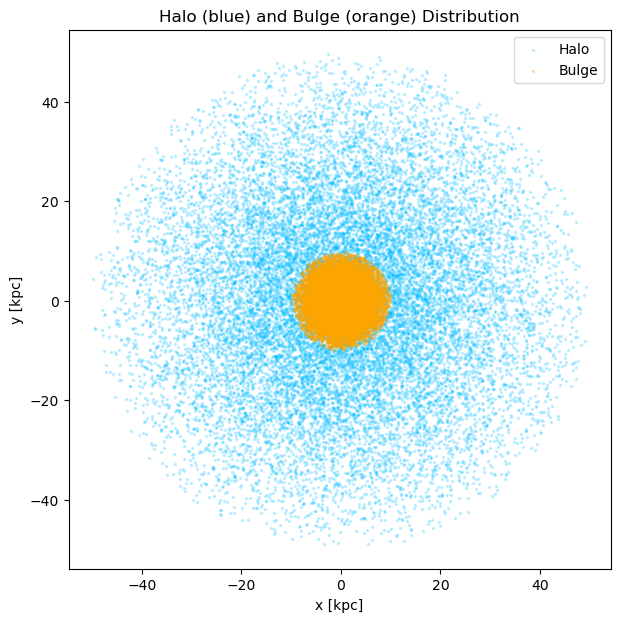

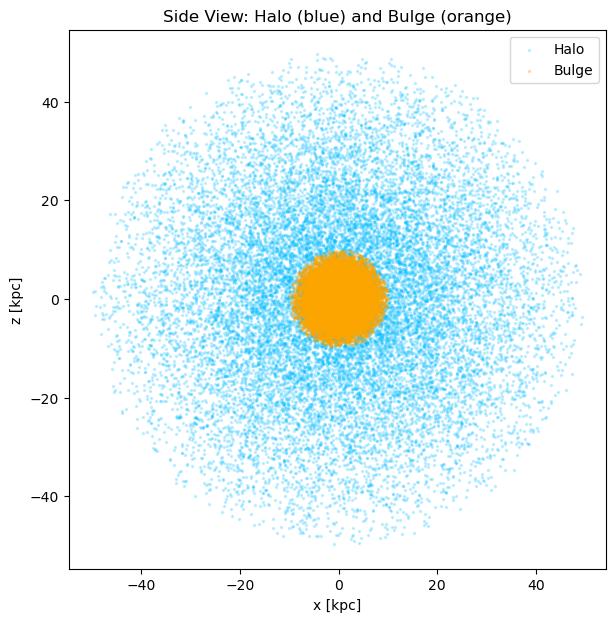

In [4]:
def sample_spherical_component(N, lR, Rmax=None):
    """
    Sample a spherical component with ρ ∝ exp(-R/lR)

    Parameters
    ----------
    N : int
        Number of stars
    lR : Quantity
        Radial scale length (e.g. 1.8 * u.kpc)
    Rmax : Quantity or None
        Optional cutoff radius

    Returns
    -------
    x, y, z : Quantity arrays
    """
    # Sample radius ~ R^2 e^{-R/lR}
    R = np.random.gamma(shape=3.0, scale=lR.value, size=N) * lR.unit
    if Rmax is not None:
        mask = R < Rmax
        R = R[mask]

    # Random direction on a sphere
    phi = np.random.uniform(0, 2*np.pi, len(R))
    cos_theta = np.random.uniform(-1, 1, len(R))
    sin_theta = np.sqrt(1 - cos_theta**2)

    # Convert to Cartesian coordinates
    x = R * sin_theta * np.cos(phi)
    y = R * sin_theta * np.sin(phi)
    z = R * cos_theta

    return x, y, z

# -----------------------------
# Bulge and Halo parameters
# -----------------------------
lR_bulge = 1.8 * u.kpc
lR_halo  = 15.0 * u.kpc

N_bulge = 30000
N_halo  = 30000

# Generate both components
x_b, y_b, z_b = sample_spherical_component(N_bulge, lR_bulge, Rmax=10*u.kpc)
x_h, y_h, z_h = sample_spherical_component(N_halo,  lR_halo,  Rmax=50*u.kpc)

# -----------------------------
# 2D projection (top-down view)
# -----------------------------
plt.figure(figsize=(7,7))
plt.scatter(x_h.value, y_h.value, s=2, alpha=0.2, color='deepskyblue', label='Halo')
plt.scatter(x_b.value, y_b.value, s=2, alpha=0.3, color='orange', label='Bulge')
plt.xlabel('x [kpc]'); plt.ylabel('y [kpc]')
plt.title('Halo (blue) and Bulge (orange) Distribution')
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.show()

# -----------------------------
# Side view (x–z plane)
# -----------------------------
plt.figure(figsize=(7,7))
plt.scatter(x_h.value, z_h.value, s=2, alpha=0.2, color='deepskyblue', label='Halo')
plt.scatter(x_b.value, z_b.value, s=2, alpha=0.3, color='orange', label='Bulge')
plt.xlabel('x [kpc]'); plt.ylabel('z [kpc]')
plt.title('Side View: Halo (blue) and Bulge (orange)')
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.show()
